<a href="https://colab.research.google.com/github/mamhamed/Reinforcement_Learning/blob/master/RL_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to train a value-based agent—specifically a
**Deep Q-Network (DQN)**—to land the lunar module safely in the classic
control benchmark *LunarLander-v3*.  Although reinforcement learning for large
language models typically relies on policy-gradient methods such as PPO (or
newer variants like GRPO), DQN remains one of the foundational and most
widely-cited algorithms in RL literature, making it a useful baseline for smaller, discrete-action tasks.


| Value Function                  | Formal Definition                                         | Intuition — “What it tells you”                                           | How to Extract/Use a Policy                                                                                                                                        |                 |
| ------------------------------- | --------------------------------------------------------- | ------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ | --------------- |
| **State Value `V(s)`**          | **E\_π \[ ∑<sub>t = 0</sub>^∞ γᵗ rₜ \| s₀ = s ]**         | “How good is it *to be in* this state under policy π?”                    | You still need a separate policy π(a \| s) (e.g., an actor network). `V(s)` is often used only as a **baseline** to reduce variance or to rank states in planning. |                 |
| **State–Action Value `Q(s,a)`** | **E\_π \[ ∑<sub>t = 0</sub>^∞ γᵗ rₜ \| s₀ = s, a₀ = a ]** | “How good is it to take **this action** in this state and then follow π?” | A greedy (or soft-max) selection over `Q(s,a)` **is** the policy: <br/> • Discrete: `a* = argmax_a Q(s,a)` <br/> • β-softmax: \`π(a                                | s) ∝ exp(Q/β)\` |


In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

action space: Discrete(4)
initial state: [ 0.0031745   1.4183462   0.32153386  0.33004856 -0.00367174 -0.07283233
  0.          0.        ]


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
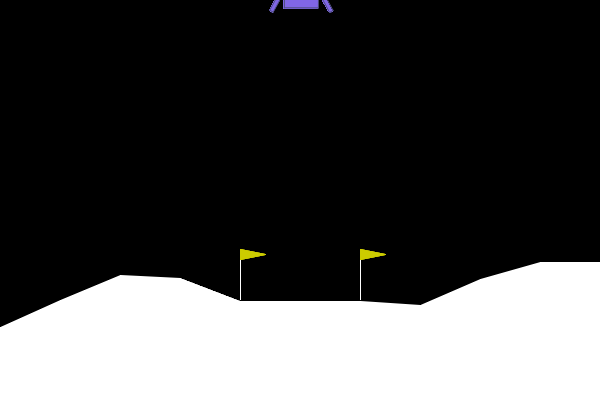

In [5]:
env_name = 'LunarLander-v3'
env = gym.make(env_name, render_mode="rgb_array")
# getting action space
print(f"action space: {env.action_space}")
s0, a0 = env.reset()
print(f"initial state: {s0}")
env.render()

**Note**

In actor-critic where the actor output is the probability of actions and hence we have `softmax` at the end of the network.

In DQN (or general Q-learning), the network output is the value of taking action `aₜ` at state `sₜ`. Therefore we return the logits w/o the softmax

In [16]:
class QNetwork(nn.Module):
  def __init__(self, state_space, action_space):
    super().__init__()
    self.ln1 = nn.Linear(state_space, 256)
    self.ln2 = nn.Linear(256, 256)
    self.ln3 = nn.Linear(256, action_space)

  def forward(self, state):
    x = self.ln1(state)
    x = F.relu(x)
    x = self.ln2(x)
    x = F.relu(x)
    x = self.ln3(x)
    return x

In [33]:
from collections import deque
import random
class ReplayBuffer:
    """Fixed‑size cyclic buffer for experience replay."""

    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)  # (s, a, r, s_next, done)

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [37]:
REPLAY_CAPACITY     = 100_000
MAX_FRAMES          = 200_000
BATCH_SIZE          = 128
gamma               = 0.995
EPSILON_END         = 0.05
EPSILON_DECAY       = 25_000
TARGET_UPDATE_FREQ  = 1_000

In [38]:
qnet = QNetwork(env.observation_space.shape[0], env.action_space.n)
qtarget = QNetwork(env.observation_space.shape[0], env.action_space.n)
qtarget.load_state_dict(qnet.state_dict())
optimizer = torch.optim.AdamW(qnet.parameters(), lr=5e-4)

replay_buffer = ReplayBuffer(REPLAY_CAPACITY)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qnet = qnet.to(device)
qtarget = qtarget.to(device)
qtarget = qtarget.eval()

Using 1-step TD
```
qtarget = r + γ maxₐ′ Qθ(s′,a′)
```

and optimizing for
```
||r + γQ′ − Q||
```

In [ ]:
st, _ = env.reset()

episode_reward = 0
epsilon = 1
for frame_idx in range(MAX_FRAMES):
  epsilon = EPSILON_END + (1.0 - EPSILON_END) * np.exp(-frame_idx / EPSILON_DECAY)
  if random.random() < epsilon:
    at = random.randint(0, env.action_space.n-1)
  else:
    with torch.no_grad():
      _st = torch.tensor(st, device=device, dtype=torch.float32)
      at = qnet(_st.unsqueeze(dim=0)).argmax(dim=-1).squeeze().item()

  next_state, rt, terminated, truncated, _ = env.step(at)
  done = terminated or truncated

  # (s, a, r, s_next, done)
  replay_buffer.push((st, at, rt, next_state, done))
  episode_reward += rt
  if done:
    st, _ = env.reset()
    print(f"Frame {frame_idx:>7} | Episode reward: {episode_reward:>7.2f} | ε: {epsilon:>.3f}")
    episode_reward = 0.0
  else:
    st = next_state

  if len(replay_buffer.buffer) >= BATCH_SIZE:
    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
    _states = torch.tensor(states, device=device, dtype=torch.float32)
    _actions = torch.tensor(actions, device=device, dtype=torch.long).unsqueeze(1)
    _next_states = torch.tensor(next_states, device=device, dtype=torch.float32)
    _dones = torch.tensor(dones, device=device, dtype=torch.float32).unsqueeze(1)
    _rewards = torch.tensor(rewards, device=device, dtype=torch.float32).unsqueeze(1)


    # get the qvals for actions chosen before, we want to optimize qnet to give best actions
    qvals = qnet(_states).gather(1, _actions)

    with torch.no_grad():
      # what is qvals for next states that is selected by qnet
      best_action = qnet(_next_states).argmax(1, keepdim=True)
      qvals_next = qtarget(_next_states).gather(-1, best_action)
      qtargetvals = _rewards + gamma * qvals_next * (1-_dones)

    loss = F.mse_loss(qvals, qtargetvals)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Target network sync
    if frame_idx % TARGET_UPDATE_FREQ == 0:
        qtarget.load_state_dict(qnet.state_dict())
